## Imports

In [70]:
from diffusers import StableDiffusionPipeline, DDIMInverseScheduler, DDIMScheduler, StableDiffusionPix2PixZeroPipeline
from transformers import BlipForConditionalGeneration, BlipProcessor
import torch
from PIL import Image
from util import img_grid

In [89]:
# base_img = Image.open("../../data/tmp/concept_bmw.jpeg")
base_img = Image.open("../../data/birk/0.png").convert("RGB")
num_steps = 100
# model_id = "stabilityai/stable-diffusion-2"
model_id = "CompVis/stable-diffusion-v1-4"

## Captioning Model

In [90]:
captioner_id = "Salesforce/blip-image-captioning-base"
processor = BlipProcessor.from_pretrained(captioner_id)
model = BlipForConditionalGeneration.from_pretrained(captioner_id, torch_dtype=torch.float16, low_cpu_mem_usage=True)

## Model Inversion Pipeline

In [91]:
inv_pipeline = StableDiffusionPix2PixZeroPipeline.from_pretrained(
    model_id,
    caption_generator=model,
    caption_processor=processor,
    torch_dtype=torch.float16,
    safety_checker=None,
)
inv_pipeline.scheduler = DDIMScheduler.from_config(inv_pipeline.scheduler.config)
inv_pipeline.inverse_scheduler = DDIMInverseScheduler.from_config(inv_pipeline.scheduler.config)
inv_pipeline.enable_model_cpu_offload()

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_pix2pix_zero.StableDiffusionPix2PixZeroPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
The config attributes {'thresholding': False, 'dynamic_thresholding_ratio': 0.995, 'sample_max_value': 1.0} were passed to DDIMInverseScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.


## Generate Caption

In [92]:
caption = inv_pipeline.generate_caption(base_img)
caption = ""

## Invert the image into latent embedding

In [93]:
generator = torch.manual_seed(0)
inv_latents = inv_pipeline.invert(caption, image=base_img, generator=generator, num_inference_steps=num_steps).latents

  0%|          | 0/99 [00:00<?, ?it/s]

## Play around with the inverted latents

In [94]:
def add_noise(tensor, mean=0, std=1):
    noise = torch.randn_like(tensor) * std + mean
    noisy_tensor = tensor + noise
    return noisy_tensor

print(f"orig latent mean: {inv_latents.mean().item():.3f}")
print(f"orig latent std: {inv_latents.std().item():.3f}")

noisy = add_noise(inv_latents, mean=0, std=0.1)

print(f"corrupted latent mean: {noisy.mean().item():.3f}")
print(f"corrupted latent std: {noisy.std().item():.3f}")

orig latent mean: 0.023
orig latent std: 0.776
corrupted latent mean: 0.022
corrupted latent std: 0.784


## Generate recon output from latents

In [95]:
final_latents = inv_latents

In [96]:
inv_pipeline.to("cpu")
pipeline = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
# pipeline.scheduler = inv_pipeline.scheduler
pipeline = pipeline.to("cuda")

# prompt = "a photo of an astronaut riding a horse on mars"
recon_image = pipeline(prompt=caption, latents=final_latents, num_inference_steps=num_steps).images[0]  

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


  0%|          | 0/100 [00:00<?, ?it/s]

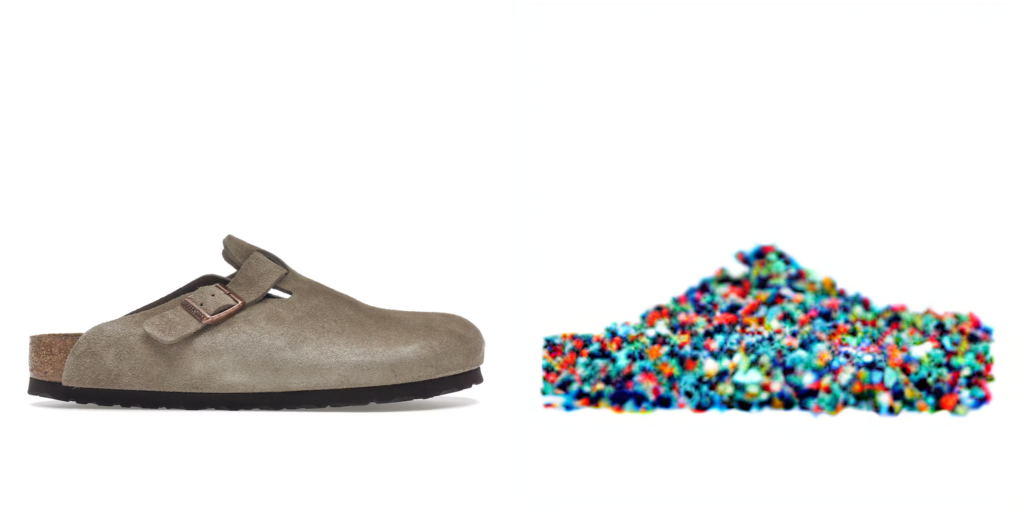

In [97]:
img_grid([base_img, recon_image], 2, 1)

## Null Text Inversion

In [1]:
import torch
import numpy as np

def preprocess(image):
    w, h = image.size
    w, h = map(lambda x: x - x % 32, (w, h))  # resize to integer multiple of 32
    image = image.resize((w, h), resample=Image.LANCZOS)
    image = np.array(image).astype(np.float32) / 255.0
    image = image[None].transpose(0, 3, 1, 2)
    image = torch.from_numpy(image)
    return 2.0 * image - 1.0

def show_lat(latents, pipe):
    # utility function for visualization of diffusion process
    with torch.no_grad():
        images = pipe.decode_latents(latents)
        print("Image statistics: ", images.mean(), images.std(), images.min(), images.max())
        im = pipe.numpy_to_pil(images)[0].resize((128, 128))
    return im

def null_text_inversion(
        pipe,
        all_latents,
        prompt,
        num_opt_steps=10,
        lr=0.01,
        tol=1e-5,
        guidance_scale=7.5,
        eta: float = 0.0,
        generator=None,
        T=50,
        negative_prompt=None
):
    # get null text embeddings for prompt
    null_text_prompt = ""
    null_text_input = pipe.tokenizer(
        null_text_prompt,
        padding="max_length",
        max_length=pipe.tokenizer.model_max_length,
        return_tensors="pt",
    )
    null_text_embeddings = torch.nn.Parameter(pipe.text_encoder(null_text_input.input_ids.to(pipe.device))[0],
                                              requires_grad=True)
    null_text_embeddings = null_text_embeddings.detach()
    null_text_embeddings.requires_grad_(True)

    # Initialize the optimizer
    optimizer = torch.optim.Adam(
        [null_text_embeddings],  # only optimize the embeddings
        lr=lr,
    )

    # step_ratio = pipe.scheduler.config.num_train_timesteps // pipe.scheduler.num_inference_steps
    text_embeddings = pipe._encode_prompt(prompt, pipe.device, 1, False, negative_prompt).detach()
    # input_embeddings = torch.cat([null_text_embeddings, text_embeddings], dim=0)
    extra_step_kwargs = pipe.prepare_extra_step_kwargs(generator, eta)
    all_null_texts = []
    latents = all_latents[-1]
    latents = latents.to(pipe.device)

    pipe.scheduler.set_timesteps(T)
    for timestep, prev_latents in pipe.progress_bar(zip(pipe.scheduler.timesteps, reversed(all_latents[:-1]))):
        prev_latents = prev_latents.to(pipe.device).detach()

        # expand the latents if we are doing classifier free guidance
        latent_model_input = pipe.scheduler.scale_model_input(latents, timestep).detach()
        noise_pred_text = pipe.unet(latent_model_input, timestep, encoder_hidden_states=text_embeddings).sample.detach()

        for idx in range(num_opt_steps):
            # predict the noise residual
            noise_pred_uncond = pipe.unet(latent_model_input, timestep,
                                          encoder_hidden_states=null_text_embeddings).sample

            # perform guidance
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

            # compute the previous noisy sample x_t -> x_t-1
            prev_latents_pred = pipe.scheduler.step(noise_pred, timestep, latents, **extra_step_kwargs).prev_sample
            loss = torch.nn.functional.mse_loss(prev_latents_pred, prev_latents).mean()

            loss.backward()
            print(idx, loss, null_text_embeddings.grad.mean())
            optimizer.step()
            optimizer.zero_grad()
            if loss < tol:
                break
        all_null_texts.append(null_text_embeddings.detach().cpu().unsqueeze(0))
        latents = prev_latents_pred.detach()
    return all_latents[-1], torch.cat(all_null_texts)

def preprocess_image(image):
    image = np.array(image.convert("RGB"))
    image = image[None].transpose(0, 3, 1, 2)
    image = torch.from_numpy(image).to(dtype=torch.float32) / 127.5 - 1.0
    return image

@torch.no_grad()
def ddim_inversion(pipe, prompt, image, T, generator=None, negative_prompt="", w=1):
    """
    DDIM based inversion of image to noise

    :param pipe: Diffusion Pipeline
    :param prompt: initial prompt
    :param image: input image that should be inversed
    :param T: num_steps of Diffusion
    :param generator: noise generator
    :param negative_prompt: negative prompt for guidance
    :param w: guidance scale
    :return: initial trajectory
    """
    pp_image = preprocess_image(image)
    latents = pipe.vae.encode(pp_image.to(pipe.device)).latent_dist.sample(generator=generator) * 0.18215


    context = pipe._encode_prompt(prompt, pipe.device, 1, False, negative_prompt)
    pipe.scheduler.set_timesteps(T)

    next_latents = latents
    all_latents = [latents.detach().cpu().unsqueeze(0)]

    for timestep, next_timestep in zip(reversed(pipe.scheduler.timesteps[1:]),
                                       reversed(pipe.scheduler.timesteps[:-1])):
        latent_model_input = pipe.scheduler.scale_model_input(next_latents, timestep)
        noise_pred = pipe.unet(latent_model_input, timestep, context).sample

        alpha_prod_t = pipe.scheduler.alphas_cumprod[timestep]
        alpha_prod_t_next = pipe.scheduler.alphas_cumprod[next_timestep]
        beta_prod_t = 1 - alpha_prod_t
        beta_prod_t_next = 1 - alpha_prod_t_next

        f = (next_latents - beta_prod_t ** 0.5 * noise_pred) / (alpha_prod_t ** 0.5)
        next_latents = alpha_prod_t_next ** 0.5 * f + beta_prod_t_next ** 0.5 * noise_pred
        all_latents.append(next_latents.detach().cpu().unsqueeze(0))

    return torch.cat(all_latents)



/home/adham/miniconda3/envs/mldev/lib/python3.8/site-packages/diffusers/configuration_utils.py:215: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a scheduler, please use <class 'diffusers.schedulers.scheduling_ddim.DDIMScheduler'>.from_pretrained(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


torch.Size([50, 1, 4, 64, 64])
Image statistics:  0.88644975 0.22862063 0.03955078 1.0
Image statistics:  0.8674678 0.22433051 0.0 1.0
Image statistics:  0.8002072 0.21827489 0.0 1.0
Image statistics:  0.69135666 0.21082743 0.0 1.0
Image statistics:  0.5714296 0.20679313 0.0 1.0


  0%|          | 0/50 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0 tensor(8.4130e-07, device='cuda:6', grad_fn=<MeanBackward0>) tensor(1.0338e-09, device='cuda:6')


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 6; 10.75 GiB total capacity; 9.69 GiB already allocated; 4.75 MiB free; 9.71 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

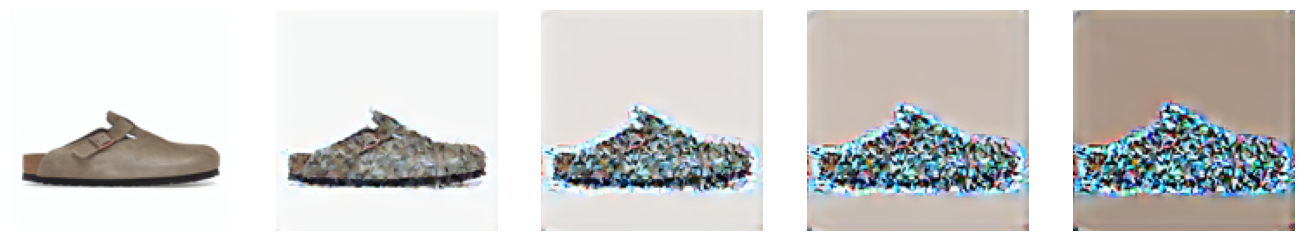

In [2]:
from pathlib import Path
from diffusers import StableDiffusionPipeline
from diffusers.schedulers import DDIMScheduler
from PIL import Image
from matplotlib import pyplot as plt

project_name = "test"
Path(f"./results/{project_name}").mkdir(parents=True, exist_ok=True)
device = "cuda:6"

model_id_or_path = "runwayml/stable-diffusion-v1-5"
scheduler = DDIMScheduler.from_config(model_id_or_path, subfolder="scheduler")
SD_pipe = StableDiffusionPipeline.from_pretrained(model_id_or_path, scheduler=scheduler).to(device)

og_image = Image.open("../../data/birk/0.png").resize((512, 512))
source_prompt = ""
T = 50
generator = torch.Generator(device=device)
init_trajectory = ddim_inversion(SD_pipe, source_prompt, og_image, T, generator)
print(init_trajectory.shape)
torch.save(init_trajectory, f"./results/{project_name}/init_trajectory.pt")

plt.figure(figsize=(20, 8))
with torch.autocast("cuda"):
    for i, traj in enumerate(init_trajectory[::10]):
        plt.subplot(1, (T // 10) + 1, i + 1)
        plt.imshow(show_lat(traj.to(device), SD_pipe))
        plt.axis("off")
plt.savefig(f"./results/{project_name}/trajectories.png")

with torch.inference_mode(), torch.autocast("cuda"):
    z_T = init_trajectory[-1].to(device)
    im = SD_pipe(prompt=source_prompt, latents=z_T, generator=generator)
    im[0][0].save(f"./results/{project_name}/DDIM_reconstruction.png")

# test

# model_id_or_path = "runwayml/stable-diffusion-v1-5"
# scheduler = DDIMScheduler.from_config(model_id_or_path, subfolder="scheduler")
# SD_pipe = StableDiffusionPipeline.from_pretrained(model_id_or_path,scheduler=scheduler).to("cuda")

# T = 50

source_prompt = ""
init_trajectory = torch.load(f"./results/{project_name}/init_trajectory.pt")
generator = torch.Generator(device=device)
z_T, null_embeddings = null_text_inversion(SD_pipe, init_trajectory, source_prompt,
                                            guidance_scale=7.5, generator=generator)

torch.save(null_embeddings, f"./results/{project_name}/nulls.pt")